In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [3]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)
simplefilter(action='ignore', category=RuntimeWarning)

In [4]:
import pandas as pd
import numpy as np
import os, re, spacy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
from pprint import pprint
from operator import itemgetter

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# pyLDAvis
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess, lemmatize
from gensim.models import CoherenceModel, LdaModel, LdaMulticore, TfidfModel, HdpModel
from gensim.models.nmf import Nmf

# Sklearn
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

C:\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [5]:
data = pd.read_csv('MBS_data.csv',index_col=0)

In [6]:
data.head()

,review_date,title,score,pros,cons,reviewer,review_country,stay_date
0,8-Feb-20,"Great location, pool area a huge plus , good d...",9.2,"Great location, pool area a huge plus , good d...",Bedroom very bland . No soft furnishings. Too ...,Deirdre,Ireland,Feb-20
1,7-Feb-20,Absolutly Brillant,10.0,The Place is very interesting and very comfy. ...,The inifinity Pool was awesome and we really e...,Prince,Australia,Jan-20
2,6-Feb-20,Not worth the money,7.1,Location and the view are the key factors to s...,The price was ridiculous I paid about $1000/ni...,Lenny,USA,Feb-20
3,5-Feb-20,If you liked Crazy Rich Asians then stay here,8.8,Out of this world hotel. We stayed one night a...,It could have been cheaper. The bar at the nig...,Kathryn,USA,Jan-20
4,5-Feb-20,"Lovely rooms, sparkling clean, great amenities...",9.6,"Lovely rooms, sparkling clean, great amenities...","Everything was so expensive, especially the re...",Robert,USA,Feb-20


In [7]:
data.shape

(5920, 8)

In [8]:
data.isnull().sum()

review_date          0
title                6
score                0
pros               311
cons              1438
reviewer             0
review_country       5
stay_date           13
dtype: int64

In [9]:
data.shape

(5920, 8)

#### Text preprocessing

In [10]:
filter_list = ['nothing','all perfect','no', 'none', 'na', 'ok', 'not a thing','everything','good','great','nil']

In [11]:
def text_preprocessing(corpus):
    corpus.dropna(inplace=True)
    corpus = corpus.str.lower().apply(lambda x: str(x).encode('ascii', errors='ignore').decode())
    corpus = corpus.replace(r'http\S+', ' ', regex=True)
    corpus = corpus.replace(r"[^A-Za-z'_]", ' ', regex=True)
    corpus = corpus.replace(r' ', np.nan).dropna()
    corpus = corpus[~corpus.isin(filter_list)]
    return corpus

In [12]:
cons_cleaned = text_preprocessing(data.cons)
cons_cleaned.reset_index(drop=True, inplace=True)

In [13]:
print(cons_cleaned.shape)

(4160,)


In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))

cons_words = list(sent_to_words(cons_cleaned))

In [15]:
contraction_dict = {
"arent":"are not",
"isnt":"is not",
"couldnt":"could not",
"doesnt":"does not",
"didnt":"did not",
"hasnt":"has not",
"hadnt":"had not",
"havent":"have not",
"wasnt":"was not",
"werent":"were not",
"aren't":"are not",
"isn't":"is not",
"couldn't":"could not",
"doesn't":"does not",
"didn't":"did not",
"hasn't":"has not",
"hadn't":"had not",
"haven't":"have not",
"wasn't":"was not",
"weren't":"were not"
}

In [16]:
def expand_contraction_words(data):
    texts_out = []
    for item in data:
        texts_out.append([contraction_dict[word] if word in contraction_dict else word for word in item])
    return texts_out

In [17]:
cons_words = list(expand_contraction_words(cons_words))  

In [18]:
def remove_stopwords(texts, sw):
    return [[word for word in doc if word not in sw] for doc in texts]

In [19]:
sw = stopwords.words('english')
sw.remove('not')
sw.remove('no')

In [20]:
cons_words_nostops = remove_stopwords(cons_words, sw)

In [21]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [22]:
bigram = gensim.models.Phrases(cons_words_nostops)
trigram = gensim.models.Phrases(bigram[cons_words_nostops]) 
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
cons_words_bigrams = make_bigrams(cons_words_nostops)
cons_words_trigrams = make_trigrams(cons_words_nostops)

In [23]:
def lemmatization(texts, allowed_postags=['PROPN','NOUN','VERB','ADJ']):
    texts_out = []
    for sent in texts:
        doc = nlp(' '.join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [24]:
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

In [25]:
cons_words_nostops = lemmatization(cons_words_nostops)
cons_words_bigrams = lemmatization(cons_words_bigrams) 
cons_words_trigrams = lemmatization(cons_words_trigrams)

In [26]:
sw2 = (['hotel','tower','little','bit','lot','think','please','much','stay','make','feel','comment','singapore','marina','bay','sands',
        'excellent', 'fantastic', 'wonderful', 'amazing', 'awesome', 'enjoy', 'perfect', 'good', 'great', 'nice', 'nothing', 'everything', 'love','thing','thank','sure'])
sw2.extend(['one','two','three','four','five','star','ten','hundred','thousand'])  
cons_words_nostops = remove_stopwords(cons_words_nostops, sw2)
cons_words_bigrams = remove_stopwords(cons_words_bigrams, sw2)
cons_words_trigrams = remove_stopwords(cons_words_trigrams, sw2)

In [27]:
def make_sentences(texts):
    texts = pd.Series([' '.join(doc) for doc in texts], name='text')
    texts_out = texts[texts.str.split().apply(len)>1]
    return texts_out

In [28]:
cons_sentences_nostops = make_sentences(cons_words_nostops)
cons_sentences_bigrams = make_sentences(cons_words_bigrams)
cons_sentences_trigrams = make_sentences(cons_words_trigrams)

In [29]:
cons_words_nostops = cons_sentences_nostops.str.split().tolist()
cons_words_bigrams = cons_sentences_bigrams.str.split().tolist()
cons_words_trigrams = cons_sentences_trigrams.str.split().tolist()

#### Word Cloud

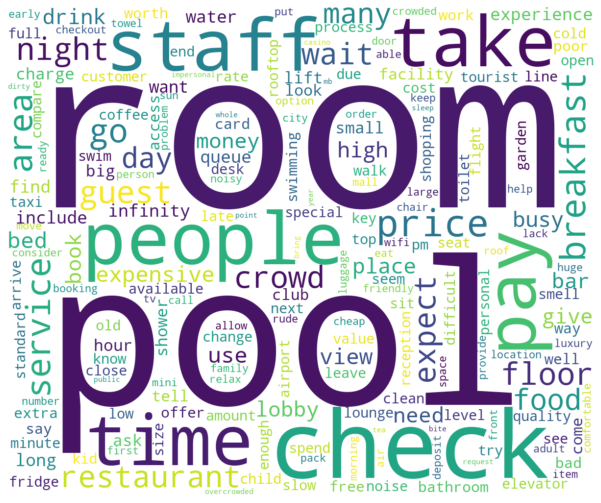

In [30]:
cons_text = ''.join([' '.join(word) for word in cons_words_nostops])
sw_set = set(STOPWORDS)     
wordcloud = WordCloud(background_color="white", width=1200, height=1000, 
                      stopwords=sw_set, collocations=False).generate(cons_text)
plt.figure(figsize = (16,9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [31]:
wordcloud.to_file('wordcloud.png')

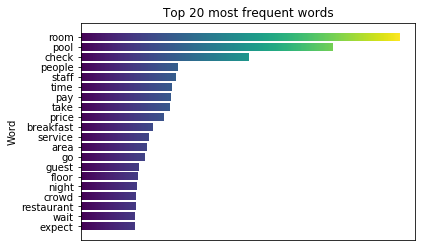

In [81]:
top_words = pd.DataFrame(list(wordcloud.words_.items())[:20],columns=['word','frequency']).iloc[::-1]

fig, ax = plt.subplots()
bars = ax.barh(top_words.word, top_words.frequency)

ax = bars[0].axes
lim = ax.get_xlim()+ax.get_ylim()
for bar in bars:
    bar.set_zorder(1)
    bar.set_facecolor("none")
    x,y = bar.get_xy()
    w, h = bar.get_width(), bar.get_height()
    grad = np.atleast_2d(np.linspace(0,1*w/max(top_words.frequency),256))

    plt.gca().imshow(grad, extent=[x,x+w,y,y+h], aspect="auto", zorder=0, norm=mpl.colors.NoNorm(vmin=0,vmax=1))
plt.gca().set_ylabel('Word')
plt.gca().set_title('Top 20 most frequent words')
plt.gca().axis(lim)
plt.gca().axes.get_xaxis().set_visible(False)
plt.savefig('top_20_words.png')

#### Topic modelling using LDA with Mallet's implementation

In [32]:
def show_keywords(model):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
    sw_set = set(STOPWORDS) 
    cloud = WordCloud(stopwords=sw,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = model.show_topics(formatted=False)
    n_rows = int(np.ceil(model.num_topics/2))
    fig, axes = plt.subplots(n_rows, 2, figsize=(n_rows*5,10), sharex=True, sharey=True)
    for i, ax in enumerate(axes.flatten()):
        if i < model.num_topics:
            fig.add_subplot(ax)
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words, max_font_size=300)
            plt.gca().imshow(cloud)
            plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
            plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    if model.num_topics % 2 ==1:
        axes[-1,-1].axis('off')
    return plt

# LDA models do not use TFIDF: https://datascience.stackexchange.com/questions/21950/why-we-should-not-feed-lda-with-tfidf

In [33]:
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'})
mallet_path = 'C:/mallet-2.0.8/bin/mallet' # update this path

In [34]:
def lda_mallet(n_topics, data, alpha, use_tfidf, show_results):
    id2word = corpora.Dictionary(data)
    id2word.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
    corpus = [id2word.doc2bow(text) for text in data]
    if use_tfidf:
        tfidf = TfidfModel(corpus)
        corpus = tfidf[corpus]
    model_mallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=n_topics, id2word=id2word, alpha=alpha, random_seed=42)
                                       
    coherence_model_mallet = CoherenceModel(model=model_mallet, texts=data, dictionary=id2word, coherence='c_v')
    coherence_mallet = coherence_model_mallet.get_coherence()  
    print('Coherence value when number of topics =', n_topics, ':', coherence_mallet)
    
    vis = None
    if show_results:
        pprint(model_mallet.print_topics(num_words=10))
        pyLDAvis.enable_notebook()
        model_mallet_vis = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model_mallet)
        vis = pyLDAvis.gensim.prepare(model_mallet_vis, corpus, id2word)
    return coherence_mallet, model_mallet, corpus, vis

#### Identify the best n-gram scenario and number of topics for LDA with Mallet's implementation

In [35]:
limit=11;start=2; step=1;

In [36]:
coherence_values = []
for n_topics in np.arange(start,limit,step):
    coherence_mallet, model_mallet, id2word, vis = lda_mallet(n_topics, cons_words_nostops, 5, False, False)
    coherence_values.append(coherence_mallet)
singleword_mallet = coherence_values

Coherence value when number of topics = 2 : 0.536961422066238
Coherence value when number of topics = 3 : 0.5635428573752118
Coherence value when number of topics = 4 : 0.5812783184544407
Coherence value when number of topics = 5 : 0.5648572548121076
Coherence value when number of topics = 6 : 0.5772666555840354
Coherence value when number of topics = 7 : 0.568497353753595
Coherence value when number of topics = 8 : 0.5607376801521251
Coherence value when number of topics = 9 : 0.5613603776010133
Coherence value when number of topics = 10 : 0.544994685251446


In [37]:
coherence_values = []  
for n_topics in np.arange(start,limit,step):
    coherence_mallet, model_mallet, id2word, vis = lda_mallet(n_topics, cons_words_bigrams, 5, False, False)
    coherence_values.append(coherence_mallet)
bigram_mallet = coherence_values

Coherence value when number of topics = 2 : 0.49491454004414015
Coherence value when number of topics = 3 : 0.5455419235044223
Coherence value when number of topics = 4 : 0.5502912789433475
Coherence value when number of topics = 5 : 0.533198132044423
Coherence value when number of topics = 6 : 0.536598544960228
Coherence value when number of topics = 7 : 0.5316986454041749
Coherence value when number of topics = 8 : 0.5117767751058533
Coherence value when number of topics = 9 : 0.49579833372192056
Coherence value when number of topics = 10 : 0.4905477079063951


In [38]:
coherence_values = []
for n_topics in np.arange(start,limit,step):
    coherence_mallet, model_mallet, id2word, vis = lda_mallet(n_topics, cons_words_trigrams, 5, False, False)
    coherence_values.append(coherence_mallet)
trigram_mallet = coherence_values

Coherence value when number of topics = 2 : 0.5125044427056458
Coherence value when number of topics = 3 : 0.5390345948282436
Coherence value when number of topics = 4 : 0.5323757103946101
Coherence value when number of topics = 5 : 0.5144170861130973
Coherence value when number of topics = 6 : 0.5258677666037371
Coherence value when number of topics = 7 : 0.5392507301524094
Coherence value when number of topics = 8 : 0.509944686634564
Coherence value when number of topics = 9 : 0.4984094622705118
Coherence value when number of topics = 10 : 0.489839537237131


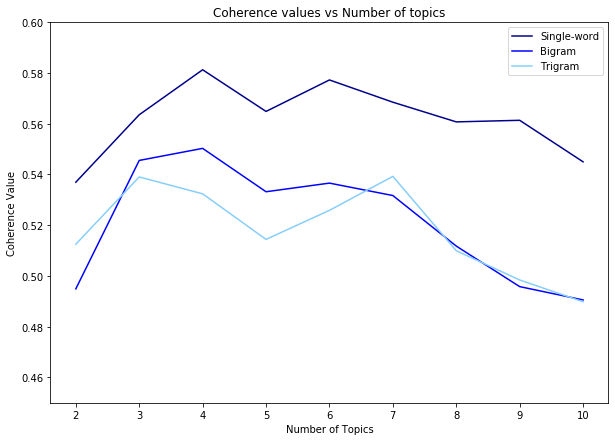

In [39]:
df_cv = pd.DataFrame(columns=['singleword', 'bigram', 'trigram'])
df_cv['singleword'] = singleword_mallet
df_cv['bigram'] = bigram_mallet
df_cv['trigram'] = trigram_mallet
df_cv.to_csv('cv_mallet_table.csv', index=False)

x = range(start, limit, step)
plt.figure(figsize=(10,7))     
plt.plot(x, singleword_mallet, color='darkblue', label='Single-word')
plt.plot(x, bigram_mallet, color='blue', label='Bigram')
plt.plot(x, trigram_mallet, color='lightskyblue',label='Trigram')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Value")
plt.ylim(0.45,0.6)
plt.xticks(np.arange(start,limit,step))
plt.legend(loc='best')
plt.title('Coherence values vs Number of topics')
plt.savefig('coherence_values_plot.png')

In [40]:
coherence_mallet_nostops, model_mallet_nostops, corpus_mallet_nostops, vis_mallet_nostops = lda_mallet(4, cons_words_nostops, 5, False, True)
# keywords_mallet_nostops = show_keywords(model_mallet_nostops)
vis_mallet_nostops

Coherence value when number of topics = 4 : 0.5812783184544407
[(0,
  '0.146*"pool" + 0.051*"people" + 0.037*"crowd" + 0.035*"area" + 0.030*"busy" '
  '+ 0.024*"lobby" + 0.024*"place" + 0.020*"infinity" + 0.017*"guest" + '
  '0.015*"crowded"'),
 (1,
  '0.071*"price" + 0.060*"room" + 0.054*"breakfast" + 0.047*"expensive" + '
  '0.034*"restaurant" + 0.032*"food" + 0.026*"high" + 0.023*"include" + '
  '0.019*"shower" + 0.018*"service"'),
 (2,
  '0.106*"check" + 0.053*"staff" + 0.039*"time" + 0.029*"wait" + '
  '0.024*"service" + 0.021*"long" + 0.020*"day" + 0.019*"queue" + 0.017*"lift" '
  '+ 0.015*"hour"'),
 (3,
  '0.115*"room" + 0.034*"pay" + 0.030*"bed" + 0.028*"night" + 0.024*"view" + '
  '0.023*"money" + 0.021*"book" + 0.020*"bar" + 0.017*"floor" + 0.017*"small"')]


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.201061  0.330140       1        1  26.708998
3      0.198728 -0.001803       2        1  25.602093
0     -0.264402 -0.290538       3        1  24.944191
1      0.266735 -0.037798       4        1  22.744719, topic_info=    Category         Freq         Term        Total  loglift  logprob
27   Default  1225.000000         pool  1225.000000  30.0000  30.0000
113  Default   950.000000        check   950.000000  29.0000  29.0000
55   Default  1534.000000         room  1534.000000  28.0000  28.0000
51   Default   543.000000        price   543.000000  27.0000  27.0000
57   Default   471.000000        staff   471.000000  26.0000  26.0000
208  Default   412.000000    breakfast   412.000000  25.0000  25.0000
108  Default   427.000000       people   427.000000  24.0000  24.0000
66   Default   354.000000    expensive   354.000000  23.0000  23.0000
99   Default   304.000000        crowd   304.000000  22.0000  22.0000
1    Default   292.000000         area   292.000000  21.0000  21.0000
53   Default   257.000000   restaurant   257.000000  20.0000  20.0000
221  Default   242.000000         food   242.000000  19.0000  19.0000
23   Default   429.000000         time   429.000000  18.0000  18.0000
187  Default   256.000000          bed   256.000000  17.0000  17.0000
188  Default   249.000000         busy   249.000000  16.0000  16.0000
217  Default   255.000000         wait   255.000000  15.0000  15.0000
49   Default   399.000000          pay   399.000000  14.0000  14.0000
13   Default   202.000000        lobby   202.000000  13.0000  13.0000
194  Default   199.000000        place   199.000000  12.0000  12.0000
46   Default   265.000000        night   265.000000  11.0000  11.0000
41   Default   208.000000         high   208.000000  10.0000  10.0000
168  Default   195.000000        money   195.000000   9.0000   9.0000
290  Default   171.000000      include   171.000000   8.0000   8.0000
56   Default   355.000000      service   355.000000   7.0000   7.0000
342  Default   184.000000         long   184.000000   6.0000   6.0000
216  Default   217.000000         view   217.000000   5.0000   5.0000
356  Default   167.000000     infinity   167.000000   4.0000   4.0000
2    Default   173.000000          bar   173.000000   3.0000   3.0000
154  Default   167.000000        queue   167.000000   2.0000   2.0000
239  Default   147.000000       shower   147.000000   1.0000   1.0000
..       ...          ...          ...          ...      ...      ...
298   Topic4    85.196564         rate    85.196564   1.4808  -4.4923
136   Topic4    78.557871      quality    78.557871   1.4808  -4.5734
180   Topic4    73.025626        clean    73.025626   1.4808  -4.6464
48    Topic4    66.386933       option    66.386933   1.4808  -4.7417
250   Topic4    63.067586          air    63.067586   1.4808  -4.7930
765   Topic4    60.854689         wifi    60.854689   1.4808  -4.8288
71    Topic4    59.748240      compare    59.748240   1.4808  -4.8471
60    Topic4    56.428893           tv    56.428893   1.4808  -4.9043
407   Topic4    42.045058          hot    42.045058   1.4808  -5.1985
368   Topic4    40.938609      amenity    40.938609   1.4808  -5.2252
299   Topic4    39.832160       buffet    39.832160   1.4808  -5.2526
30    Topic4    35.406364        bidet    35.406364   1.4808  -5.3703
81    Topic4    34.299915    overprice    34.299915   1.4808  -5.4021
74    Topic4    28.767671     internet    28.767671   1.4808  -5.5780
254   Topic4    27.661222  temperature    27.661222   1.4808  -5.6172
8     Topic4    26.554773       dinner    26.554773   1.4808  -5.6580
689   Topic4    25.448324      english    25.448324   1.4808  -5.7006
41    Topic4   198.054350         high   208.413909   1.4299  -3.6487
463   Topic4    57.535342          eat    58.686404   1.4610  -4.8848
82    Topic4    97.367502         poor   110.071327   1.3582  -

In [41]:
pyLDAvis.save_html(vis_mallet_nostops, 'vis_mallet_nostops.html')

Coherence value when number of topics = 4 : 0.5502912789433475
[(0,
  '0.070*"price" + 0.046*"expensive" + 0.045*"breakfast" + 0.043*"room" + '
  '0.042*"pay" + 0.029*"restaurant" + 0.027*"service" + 0.026*"food" + '
  '0.025*"high" + 0.019*"drink"'),
 (1,
  '0.150*"room" + 0.026*"bed" + 0.022*"book" + 0.019*"floor" + 0.018*"charge" '
  '+ 0.015*"shower" + 0.015*"bathroom" + 0.013*"night" + 0.013*"toilet" + '
  '0.012*"view"'),
 (2,
  '0.102*"check" + 0.055*"staff" + 0.040*"time" + 0.026*"wait" + 0.018*"lift" '
  '+ 0.015*"service" + 0.015*"hour" + 0.014*"day" + 0.014*"guest" + '
  '0.012*"queue"'),
 (3,
  '0.096*"pool" + 0.038*"crowd" + 0.032*"busy" + 0.030*"people" + '
  '0.024*"lobby" + 0.023*"place" + 0.021*"infinity_pool" + 0.020*"area" + '
  '0.018*"big" + 0.018*"guest"')]


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.220649  0.296887       1        1  26.730836
1     -0.280863  0.094120       2        1  25.406563
3      0.250393 -0.257471       3        1  24.332264
0     -0.190179 -0.133537       4        1  23.530337, topic_info=    Category         Freq                Term        Total  loglift  logprob
55   Default  1494.000000                room  1494.000000  30.0000  30.0000
113  Default   843.000000               check   843.000000  29.0000  29.0000
26   Default   822.000000                pool   822.000000  28.0000  28.0000
51   Default   511.000000               price   511.000000  27.0000  27.0000
57   Default   458.000000               staff   458.000000  26.0000  26.0000
66   Default   334.000000           expensive   334.000000  25.0000  25.0000
205  Default   327.000000           breakfast   327.000000  24.0000  24.0000
98   Default   288.000000               crowd   288.000000  23.0000  23.0000
49   Default   337.000000                 pay   337.000000  22.0000  22.0000
27   Default   370.000000                time   370.000000  21.0000  21.0000
185  Default   239.000000                busy   239.000000  20.0000  20.0000
213  Default   212.000000                wait   212.000000  19.0000  19.0000
292  Default   201.000000                 bed   201.000000  18.0000  18.0000
107  Default   248.000000              people   248.000000  17.0000  17.0000
217  Default   187.000000                food   187.000000  16.0000  16.0000
40   Default   181.000000                high   181.000000  15.0000  15.0000
13   Default   180.000000               lobby   180.000000  14.0000  14.0000
53   Default   257.000000          restaurant   257.000000  13.0000  13.0000
56   Default   319.000000             service   319.000000  12.0000  12.0000
227  Default   173.000000                book   173.000000  11.0000  11.0000
356  Default   159.000000       infinity_pool   159.000000  10.0000  10.0000
1    Default   152.000000                area   152.000000   9.0000   9.0000
264  Default   151.000000               floor   151.000000   8.0000   8.0000
92   Default   151.000000                lift   151.000000   7.0000   7.0000
192  Default   198.000000               place   198.000000   6.0000   6.0000
9    Default   136.000000               drink   136.000000   5.0000   5.0000
30   Default   139.000000              charge   139.000000   4.0000   4.0000
200  Default   120.000000             crowded   120.000000   3.0000   3.0000
12   Default   247.000000               guest   247.000000   2.0000   2.0000
355  Default   220.000000              expect   220.000000   1.0000   1.0000
..       ...          ...                 ...          ...      ...      ...
323   Topic4    57.299781                rate    57.299781   1.4469  -4.8472
71    Topic4    50.688268             compare    50.688268   1.4469  -4.9698
206   Topic4    48.484430       disappointing    48.484430   1.4469  -5.0143
174   Topic4    47.382511         value_money    47.382511   1.4469  -5.0373
265   Topic4    46.280593              pricey    46.280593   1.4469  -5.0608
279   Topic4    45.178674  breakfast_included    45.178674   1.4469  -5.0849
567   Topic4    40.770998          little_bit    40.770998   1.4469  -5.1875
29    Topic4    36.363323               basic    36.363323   1.4469  -5.3019
359   Topic4    34.159485        would_expect    34.159485   1.4469  -5.3645
81    Topic4    34.159485           overprice    34.159485   1.4469  -5.3645
448   Topic4    33.057566             average    33.057566   1.4469  -5.3973
559   Topic4    31.955647          food_drink    31.955647   1.4469  -5.4312
472   Topic4    30.853728              dollar    30.853728   1.4469  -5.4663
74    Topic4    28.649891            internet    28.649891   1.4469  -5.5404
49    Topic4   304.129608                 pay   337.066970   1.3441  -3.1781
53    Topic4  

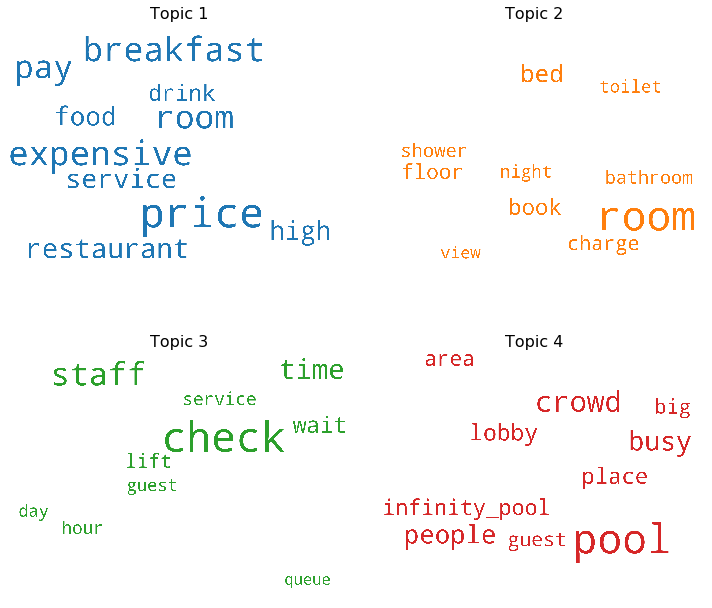

In [42]:
coherence_mallet, model_mallet, corpus_mallet, vis_mallet = lda_mallet(4, cons_words_bigrams, 5, False, True)
keywords_mallet = show_keywords(model_mallet)
vis_mallet

In [43]:
pyLDAvis.save_html(vis_mallet, 'vis_mallet.html')

In [44]:
alpha_range = [0.01,0.05,0.1,0.5,1,5,10,50,100]
id2word = corpora.Dictionary(cons_words_bigrams)
id2word.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
corpus = [id2word.doc2bow(text) for text in cons_words_bigrams]
coherence_values = []
for alpha in alpha_range:
    model_mallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=4, id2word=id2word, alpha=alpha, random_seed=42)
    coherence_model_mallet = CoherenceModel(model=model_mallet, texts=cons_words_bigrams, dictionary=id2word, coherence='c_v')
    coherence_mallet = coherence_model_mallet.get_coherence()  
    print('Coherence value when alpha =', alpha, ':', coherence_mallet) 
    coherence_values.append(coherence_mallet)

Coherence value when alpha = 0.01 : 0.5227115645607114
Coherence value when alpha = 0.05 : 0.5273389312281191
Coherence value when alpha = 0.1 : 0.5274288549784014
Coherence value when alpha = 0.5 : 0.5590665373379702
Coherence value when alpha = 1 : 0.522621192107769
Coherence value when alpha = 5 : 0.5502912789433475
Coherence value when alpha = 10 : 0.5082341246904328
Coherence value when alpha = 50 : 0.48431621128845315
Coherence value when alpha = 100 : 0.47980199440996674


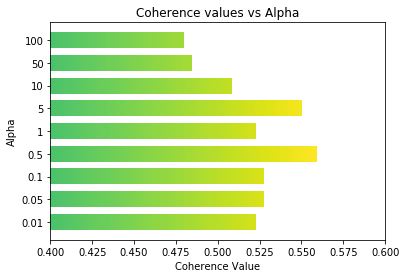

In [48]:
cv_mallet_tuned = coherence_values
alpha_range_category = [str(x) for x in alpha_range]
fig, ax = plt.subplots()
bars = ax.barh(alpha_range_category, cv_mallet_tuned, 0.7)
ax.set_xlim(0.4,0.6)
ax = bars[0].axes
lim = ax.get_xlim()+ax.get_ylim()
for bar in bars:
    bar.set_zorder(1)
    bar.set_facecolor("none")
    x,y = bar.get_xy()
    w, h = bar.get_width(), bar.get_height()
    grad = np.atleast_2d(np.linspace(0,1*w/max(cv_mallet_tuned),256))

    plt.gca().imshow(grad, extent=[x,x+w,y,y+h], aspect="auto", zorder=0, norm=mpl.colors.NoNorm(vmin=0,vmax=1))
plt.gca().set_xlabel('Coherence Value')
plt.gca().set_ylabel('Alpha')
plt.gca().set_title('Coherence values vs Alpha')
plt.gca().axis(lim)
plt.savefig('mallet_alpha_plot.png')

Coherence value when number of topics = 4 : 0.5590665373379702
[(0,
  '0.063*"pool" + 0.033*"crowd" + 0.027*"busy" + 0.021*"lobby" + '
  '0.020*"people" + 0.017*"place" + 0.015*"area" + 0.015*"infinity_pool" + '
  '0.014*"crowded" + 0.014*"guest"'),
 (1,
  '0.114*"room" + 0.026*"bed" + 0.016*"bathroom" + 0.015*"floor" + '
  '0.015*"toilet" + 0.014*"shower" + 0.012*"smell" + 0.011*"book" + '
  '0.011*"small" + 0.011*"water"'),
 (2,
  '0.081*"check" + 0.036*"staff" + 0.033*"room" + 0.028*"time" + 0.020*"wait" '
  '+ 0.018*"pool" + 0.013*"service" + 0.012*"day" + 0.012*"guest" + '
  '0.011*"hour"'),
 (3,
  '0.068*"price" + 0.054*"room" + 0.043*"expensive" + 0.041*"breakfast" + '
  '0.033*"pay" + 0.027*"food" + 0.025*"service" + 0.023*"restaurant" + '
  '0.023*"high" + 0.020*"pool"')]


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.146607  0.111001       1        1  29.389407
0     -0.226422 -0.102966       2        1  25.515626
3      0.199266 -0.221312       3        1  22.645354
1      0.173763  0.213277       4        1  22.449613, topic_info=    Category         Freq           Term        Total  loglift  logprob
113  Default   842.000000          check   842.000000  30.0000  30.0000
55   Default  1487.000000           room  1487.000000  29.0000  29.0000
51   Default   516.000000          price   516.000000  28.0000  28.0000
66   Default   338.000000      expensive   338.000000  27.0000  27.0000
205  Default   330.000000      breakfast   330.000000  26.0000  26.0000
98   Default   288.000000          crowd   288.000000  25.0000  25.0000
217  Default   188.000000           food   188.000000  24.0000  24.0000
26   Default   823.000000           pool   823.000000  23.0000  23.0000
185  Default   240.000000           busy   240.000000  22.0000  22.0000
292  Default   198.000000            bed   198.000000  21.0000  21.0000
49   Default   341.000000            pay   341.000000  20.0000  20.0000
27   Default   369.000000           time   369.000000  19.0000  19.0000
13   Default   180.000000          lobby   180.000000  18.0000  18.0000
40   Default   183.000000           high   183.000000  17.0000  17.0000
231  Default   113.000000       bathroom   113.000000  16.0000  16.0000
56   Default   321.000000        service   321.000000  15.0000  15.0000
213  Default   211.000000           wait   211.000000  14.0000  14.0000
53   Default   260.000000     restaurant   260.000000  13.0000  13.0000
57   Default   455.000000          staff   455.000000  12.0000  12.0000
59   Default   101.000000         toilet   101.000000  11.0000  11.0000
200  Default   121.000000        crowded   121.000000  10.0000  10.0000
264  Default   150.000000          floor   150.000000   9.0000   9.0000
9    Default   138.000000          drink   138.000000   8.0000   8.0000
290  Default   102.000000        include   102.000000   7.0000   7.0000
330  Default    82.000000          smell    82.000000   6.0000   6.0000
234  Default   118.000000         shower   118.000000   5.0000   5.0000
84   Default   141.000000          small   141.000000   4.0000   4.0000
192  Default   199.000000          place   199.000000   3.0000   3.0000
123  Default    71.000000         fridge    71.000000   2.0000   2.0000
227  Default   173.000000           book   173.000000   1.0000   1.0000
..       ...          ...            ...          ...      ...      ...
427   Topic4    17.933674     connection    17.933674   1.4939  -5.9618
46    Topic4    16.812820       no_bidet    16.812820   1.4939  -6.0263
337   Topic4    16.812820      extra_bed    16.812820   1.4939  -6.0263
24    Topic4    41.471622  uncomfortable    42.583107   1.4674  -5.1235
292   Topic4   178.215889            bed   198.361399   1.3868  -3.6655
352   Topic4    65.009569          noise    74.021111   1.3641  -4.6740
234   Topic4    96.393499         shower   118.209027   1.2899  -4.2801
300   Topic4    25.779657           hard    26.891142   1.4517  -5.5989
55    Topic4   791.323379           room  1487.960243   0.8624  -2.1748
101   Topic4    38.109058          adult    43.705033   1.3569  -5.2080
264   Topic4   103.118627          floor   150.194239   1.1178  -4.2126
134   Topic4    42.592477            put    50.629776   1.3210  -5.0968
128   Topic4    41.471622           item    49.252021   1.3220  -5.1235
31    Topic4    44.834186         coffee    57.145331   1.2513  -5.0455
146   Topic4    73.976407          water   123.190149   0.9839  -4.5447
84    Topic4    75.097261          small   141.786397   0.8584  -4.5297
63    Topic4    59.405296           work    99.591794   0.9772  -4.7641
618   Topic4    43.713331            low    61.497101   1.1526  -5.0708
280   Topic4    47.075895        

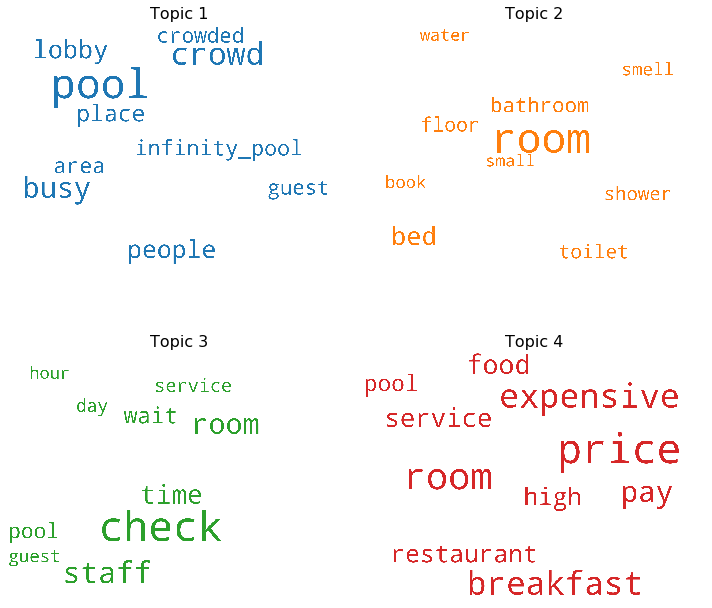

In [49]:
coherence_optimal, model_optimal, corpus_optimal, vis_optimal = lda_mallet(4, cons_words_bigrams, 0.5, False, True)
keywords_optimal = show_keywords(model_optimal)
vis_optimal

In [50]:
keywords_optimal.savefig('keywords_optimal.png')
pyLDAvis.save_html(vis_optimal, 'vis_optimal.html')

<Figure size 432x288 with 0 Axes>

#### Use baseline LDA model to benchmark the modelling results 

In [51]:
def lda_model(n_topics, data, alpha, use_tfidf, show_results):
    id2word = corpora.Dictionary(data)
    id2word.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
    corpus = [id2word.doc2bow(text) for text in data]
    if use_tfidf:
        tfidf = TfidfModel(corpus)
        corpus = tfidf[corpus]
    model_lda = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=1000,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True,
                                           alpha=alpha)
                                       
    coherence_model_lda = CoherenceModel(model=model_lda, texts=data, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()  
    print('Coherence value when number of topics =', n_topics, ':', coherence_lda)
    vis = None
    if show_results:
        pprint(model_lda.print_topics(num_words=10))
        pyLDAvis.enable_notebook()
        vis = pyLDAvis.gensim.prepare(model_lda, corpus, id2word)
    return coherence_lda, model_lda, corpus, vis

Coherence value when number of topics = 4 : 0.5132092410520409
[(0,
  '0.088*"check" + 0.028*"breakfast" + 0.025*"take" + 0.024*"room" + '
  '0.022*"wait" + 0.020*"time" + 0.014*"lift" + 0.012*"hour" + 0.011*"day" + '
  '0.011*"lobby"'),
 (1,
  '0.056*"price" + 0.036*"service" + 0.025*"expensive" + 0.024*"high" + '
  '0.021*"pay" + 0.019*"time" + 0.015*"expect" + 0.013*"room" + 0.013*"get" + '
  '0.012*"experience"'),
 (2,
  '0.118*"room" + 0.019*"bed" + 0.018*"view" + 0.014*"pay" + 0.014*"book" + '
  '0.012*"small" + 0.011*"bathroom" + 0.011*"floor" + 0.010*"toilet" + '
  '0.010*"need"'),
 (3,
  '0.081*"pool" + 0.039*"staff" + 0.031*"crowd" + 0.024*"restaurant" + '
  '0.022*"busy" + 0.021*"people" + 0.016*"guest" + 0.016*"food" + 0.013*"big" '
  '+ 0.012*"place"')]


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.104876 -0.012689       1        1  26.922804
3     -0.225032  0.005066       2        1  25.338238
0      0.054263 -0.169246       3        1  25.137806
1      0.065893  0.176869       4        1  22.601147, topic_info=    Category         Freq           Term        Total  loglift  logprob
113  Default   746.000000          check   746.000000  30.0000  30.0000
55   Default  1286.000000           room  1286.000000  29.0000  29.0000
26   Default   714.000000           pool   714.000000  28.0000  28.0000
51   Default   477.000000          price   477.000000  27.0000  27.0000
56   Default   287.000000        service   287.000000  26.0000  26.0000
98   Default   266.000000          crowd   266.000000  25.0000  25.0000
40   Default   169.000000           high   169.000000  24.0000  24.0000
57   Default   402.000000          staff   402.000000  23.0000  23.0000
213  Default   185.000000           wait   185.000000  22.0000  22.0000
205  Default   312.000000      breakfast   312.000000  21.0000  21.0000
53   Default   227.000000     restaurant   227.000000  20.0000  20.0000
292  Default   179.000000            bed   179.000000  19.0000  19.0000
144  Default   250.000000           take   250.000000  18.0000  18.0000
27   Default   310.000000           time   310.000000  17.0000  17.0000
185  Default   219.000000           busy   219.000000  16.0000  16.0000
49   Default   284.000000            pay   284.000000  15.0000  15.0000
212  Default   169.000000           view   169.000000  14.0000  14.0000
217  Default   172.000000           food   172.000000  13.0000  13.0000
107  Default   212.000000         people   212.000000  12.0000  12.0000
66   Default   321.000000      expensive   321.000000  11.0000  11.0000
231  Default    95.000000       bathroom    95.000000  10.0000  10.0000
92   Default   135.000000           lift   135.000000   9.0000   9.0000
59   Default    89.000000         toilet    89.000000   8.0000   8.0000
13   Default   163.000000          lobby   163.000000   7.0000   7.0000
227  Default   146.000000           book   146.000000   6.0000   6.0000
207  Default   106.000000           hour   106.000000   5.0000   5.0000
794  Default    63.000000           wifi    63.000000   4.0000   4.0000
329  Default   108.000000    many_people   108.000000   3.0000   3.0000
264  Default   128.000000          floor   128.000000   2.0000   2.0000
187  Default    75.000000           cold    75.000000   1.0000   1.0000
..       ...          ...            ...          ...      ...      ...
445   Topic4    23.818598           sand    27.088608   1.3585  -5.6848
535   Topic4    37.657612     overpriced    44.065208   1.3300  -5.2267
323   Topic4    44.024483           rate    52.365040   1.3137  -5.0705
444   Topic4    47.504150     marina_bay    59.162128   1.2677  -4.9944
359   Topic4    26.001610   would_expect    30.951031   1.3129  -5.5971
285   Topic4    67.174019           slow    89.034920   1.2054  -4.6479
174   Topic4    37.280064    value_money    46.194405   1.2728  -5.2368
317   Topic4    68.265945           cost    96.278061   1.1433  -4.6318
585   Topic4    33.444717       personal    42.739864   1.2419  -5.3453
66    Topic4   178.640457      expensive   321.290039   0.9002  -3.6698
220   Topic4    68.442078         access   102.850647   1.0799  -4.6292
322   Topic4    58.906292          offer    87.268898   1.0941  -4.7793
36    Topic4    60.399639           free    91.176697   1.0754  -4.7542
9     Topic4    77.381531          drink   124.923431   1.0082  -4.5065
49    Topic4   146.606735            pay   284.600403   0.8238  -3.8675
355   Topic4   106.815155         expect   194.771576   0.8864  -4.1841
35    Topic4    86.043396     experience   148.359772   0.9424  -4.4004
82    Topic4    60.090160           poor    92.826553   1.0523  -4.7594
65    Topic4    56.280823        

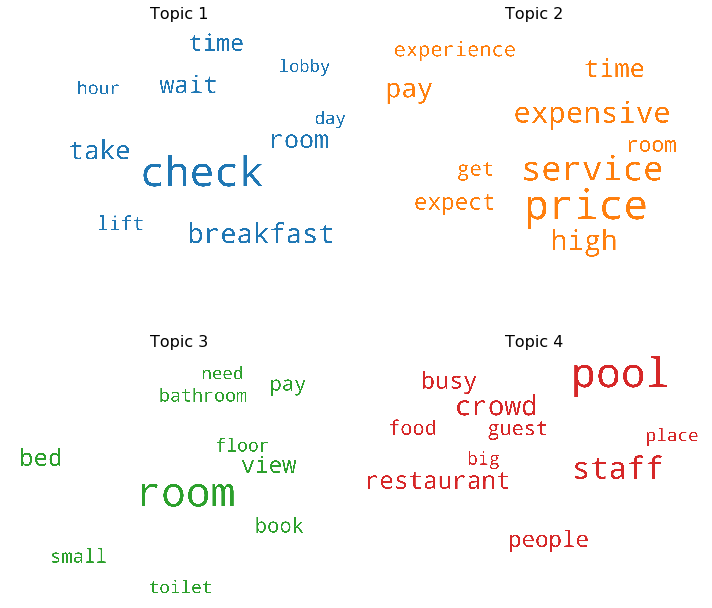

In [52]:
coherence_lda, benchmark_model_lda, corpus, vis = lda_model(4, cons_words_bigrams, 0.5, False, True)
keywords_lda = show_keywords(benchmark_model_lda)
benchmark_vis_lda = vis
benchmark_vis_lda

In [53]:
keywords_lda.savefig('keywords_lda.png')
pyLDAvis.save_html(benchmark_vis_lda, 'vis_lda.html')

<Figure size 432x288 with 0 Axes>

#### NMF Topic Modelling

In [54]:
def nmf_model(n_topics, data, kappa, use_tfidf):
    id2word = corpora.Dictionary(data)
    id2word.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
    corpus = [id2word.doc2bow(text) for text in data]
    if use_tfidf:
        tfidf = TfidfModel(corpus)
        corpus = tfidf[corpus]
                                  
    model_nmf = Nmf(corpus=corpus,
                   id2word=id2word,
                   num_topics=n_topics, 
                   random_state=42,
                   chunksize=100,
                   passes=10,
                   kappa=kappa)
    
    coherence_model_nmf = CoherenceModel(model=model_nmf, texts=data, dictionary=id2word, coherence='c_v')
    coherence_nmf = coherence_model_nmf.get_coherence()  
    print('Coherence value when kappa =', kappa, ':', coherence_nmf)
    return coherence_nmf, model_nmf, corpus

In [55]:
kappa_range = [0.01,0.05,0.1,0.5,1,5,10,50,100]
coherence_values = []
for kappa in kappa_range:
    coherence_nmf, model_nmf, corpus = nmf_model(4, cons_words_bigrams, kappa, True)
    coherence_values.append(coherence_nmf)

C:\Anaconda3\lib\site-packages\gensim\models\nmf.py:588: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(corpus, collections.Iterator) and self.passes > 1:


Coherence value when kappa = 0.01 : 0.43734004308806096
Coherence value when kappa = 0.05 : 0.47757918172932345
Coherence value when kappa = 0.1 : 0.4720158555089473
Coherence value when kappa = 0.5 : 0.4724615579963641
Coherence value when kappa = 1 : 0.4675256017977288
Coherence value when kappa = 5 : 0.4243550728664132
Coherence value when kappa = 10 : 0.4630184309038582
Coherence value when kappa = 50 : 0.434152309579439
Coherence value when kappa = 100 : 0.46886515434056586


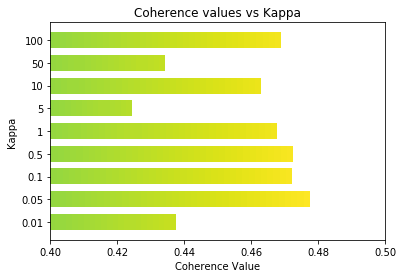

In [56]:
cv_nmf_tuned = coherence_values
kappa_range_category = [str(x) for x in kappa_range]
fig, ax = plt.subplots()
bars = ax.barh(kappa_range_category, cv_nmf_tuned, 0.7)
ax.set_xlim(0.4,0.5)
ax = bars[0].axes
lim = ax.get_xlim()+ax.get_ylim()
for bar in bars:
    bar.set_zorder(1)
    bar.set_facecolor("none")
    x,y = bar.get_xy()
    w, h = bar.get_width(), bar.get_height()
    grad = np.atleast_2d(np.linspace(0,1*w/max(cv_nmf_tuned),256))

    plt.gca().imshow(grad, extent=[x,x+w,y,y+h], aspect="auto", zorder=0, norm=mpl.colors.NoNorm(vmin=0,vmax=1))
plt.gca().set_xlabel('Coherence Value')
plt.gca().set_ylabel('Kappa')
plt.gca().set_title('Coherence values vs Kappa')
plt.gca().axis(lim)
plt.savefig('nmf_kappa_plot.png')

Coherence value when kappa = 0.5 : 0.4724615579963641
[(0,
  '0.044*"room" + 0.017*"service" + 0.012*"staff" + 0.011*"view" + 0.011*"bed" '
  '+ 0.011*"pay" + 0.008*"get" + 0.008*"book" + 0.007*"need" + 0.007*"expect"'),
 (1,
  '0.122*"pool" + 0.111*"crowd" + 0.034*"busy" + 0.025*"lobby" + '
  '0.019*"people" + 0.017*"crowded" + 0.015*"many_people" + 0.014*"cold" + '
  '0.011*"big" + 0.011*"relax"'),
 (2,
  '0.113*"check" + 0.040*"time" + 0.027*"wait" + 0.023*"take" + 0.018*"queue" '
  '+ 0.015*"staff" + 0.014*"hour" + 0.014*"slow" + 0.013*"busy" + '
  '0.011*"long_queue"'),
 (3,
  '0.153*"price" + 0.134*"expensive" + 0.085*"breakfast" + 0.062*"high" + '
  '0.036*"food" + 0.034*"restaurant" + 0.033*"include" + '
  '0.018*"breakfast_included" + 0.017*"drink" + 0.014*"pay"')]


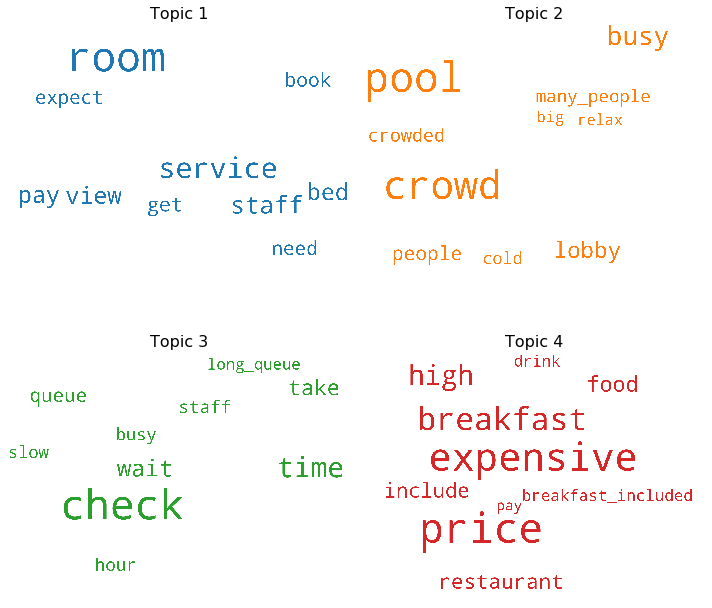

In [57]:
coherence_nmf, model_nmf, corpus = nmf_model(4, cons_words_bigrams, 0.5, True)
pprint(model_nmf.print_topics(num_words=10))
keywords_nmf = show_keywords(model_nmf)

In [58]:
keywords_nmf.savefig('keywords_nmf.png')

<Figure size 432x288 with 0 Axes>

#### Assign documents into topics

In [59]:
def format_topics_sentences(model, corpus, texts):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(model[corpus]):
        row_fill = []
        sorted_row = sorted(row, key=lambda x: (x[1]), reverse=True)
        topic_num, prop_topic = sorted_row[0]
        wp = model.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        row_fill.extend([int(topic_num + 1), topic_keywords])
        for (word, prop) in row:
            row_fill.append(prop)
        sent_topics_df = sent_topics_df.append(pd.Series(row_fill),ignore_index=True)
    sent_topics_df.columns = ['dominant_topic', 'topic_keywords','perc_topic1', 'perc_topic2', 'perc_topic3', 'perc_topic4']
    sent_topics_df = pd.concat([texts, sent_topics_df], axis=1)
    sent_topics_df.dominant_topic = sent_topics_df.dominant_topic.apply(int)
    return sent_topics_df

In [60]:
cons_sentences_bigrams.reset_index(drop=True, inplace=True)
df_topics = format_topics_sentences(model_optimal, corpus_optimal, cons_sentences_bigrams)
df_topics.sample(20)

,text,dominant_topic,topic_keywords,perc_topic1,perc_topic2,perc_topic3,perc_topic4
1961,short long time period,3,"check, staff, room, time, wait, pool, service,...",0.226190,0.067460,0.670635,0.035714
2362,pooltoo people dirtycan swim take photo,1,"pool, crowd, busy, lobby, people, place, area,...",0.892857,0.035714,0.035714,0.035714
3378,ridiculous price drink ruin experience,4,"price, room, expensive, breakfast, pay, food, ...",0.265152,0.022727,0.022727,0.689394
2033,food roof restaurant pool mass type fresh,4,"price, room, expensive, breakfast, pay, food, ...",0.298148,0.016667,0.016667,0.668519
2369,bed mattress,2,"room, bed, bathroom, floor, toilet, shower, sm...",0.050000,0.850000,0.050000,0.050000
2309,la reception,3,"check, staff, room, time, wait, pool, service,...",0.379630,0.083333,0.453704,0.083333
1190,pool expect busy bed,1,"pool, crowd, busy, lobby, people, place, area,...",0.694444,0.151235,0.052469,0.101852
814,access fridge price night extreme compare price,4,"price, room, expensive, breakfast, pay, food, ...",0.087607,0.292735,0.087607,0.532051
1305,confusing transfer elevator restaurant eat fin...,1,"pool, crowd, busy, lobby, people, place, area,...",0.816667,0.016667,0.150000,0.016667
3321,drink expensive,4,"price, room, expensive, breakfast, pay, food, ...",0.050000,0.050000,0.094444,0.805556


In [61]:
df_topics.to_csv('Topic assignment per document.csv', index=False)

In [62]:
dominant_topics = df_topics.dominant_topic.value_counts().sort_index()
topic_perc = df_topics[df_topics.columns[3:]].apply(sum)
count_dominant = dominant_topics/len(df_topics)
count_weighted = topic_perc/len(df_topics)
df_topics_count = pd.DataFrame(columns=['dominant_topic', 'topic_weightage'])
df_topics_count['dominant_topic'] = count_dominant.tolist()
df_topics_count['topic_weightage'] = count_weighted.tolist()
df_topics_count.index = np.arange(1,5)
df_topics_count.to_csv('df_topics_count.csv')

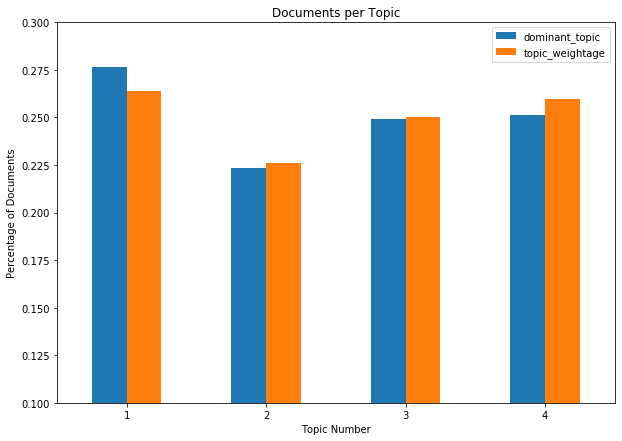

In [63]:
fig, ax = plt.subplots(figsize=(10,7))
df_topics_count.plot(y=['dominant_topic', 'topic_weightage'], kind='bar', ax=ax)
ax.set_ylim(0.1,0.3)
ax.set_xlabel('Topic Number')
ax.set_ylabel('Percentage of Documents')
ax.legend(loc='best')
plt.title('Documents per Topic')
plt.xticks(rotation=0)
plt.savefig('Documents_per_topic.png')